# Graph Convolution Network

This Jupyter notebook details the different steps of the graph convolution network (GCN). <br>
The notebook was implemented by <i>Mohammed Amine Gharsallaoui</i>, researcher at BASIRA lab, ITU.<br>
The topics covered in this notebook are: <br>
1. Graph visualization <br>
2. GCN training <br>
3. Step by step visualization of a single GC layer <br>

<b> Resources </b>: <br>
https://arxiv.org/abs/1609.02907 <br>
https://github.com/tkipf/pygcn <br>
https://github.com/tkipf/gcn <br>

# Import section

In [1]:
import numpy as np 
import networkx as nx 
import torch 
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import math
import time
import pickle
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Graph visualization 

The following cell generates a random single-edge graph with $n$ nodes. <br>The generated graph is generated using networkx library. <br>The edges in the resulting graph are weighted. 

In [2]:
def generate_graph(num_nodes):
    G = nx.Graph()
    node_list = [(i+1, {'att':[round(random.uniform(3.5, 0.5), 1) for j in range(num_nodes)]}) for i in range(num_nodes)]
    G.add_nodes_from(node_list)
    nodes = [i+1 for i in range(num_nodes)]
    edge_list = []
    for i in range(num_nodes):
        for j in range(num_nodes):
            if nodes[j]>nodes[i]:
                edge_list.append([nodes[i],nodes[j]])
    random_item_from_list = random.choice(edge_list)
    edge_list.remove(random_item_from_list)
    edge_list_weighted = [(edge_list[i][0], edge_list[i][1], {'weight': round(random.uniform(3.5, 0.5), 1)}) for i in range(len(edge_list))]            
    G.add_edges_from(edge_list_weighted)
    return G

The method <b>extract_adj() </b> extracts the adjacency matrix of a given graph $G$. <br>
The method <b>extract_feat() </b> extracts the node features matrix of a given graph $G$

In [3]:
# extract adjacency
def extract_adj(G):
    A_sparse = nx.adjacency_matrix(G)
    A_dense = A_sparse.todense() 
    return (np.array(A_dense))
    #print(A_dense)

# extract node features' matrix
def extract_feat(G):
    node_features = nx.get_node_attributes(G, "att")
    num_nodes = G.number_of_nodes()
    features_mat = np.zeros((num_nodes,num_nodes))
    for i in range(num_nodes):
        features_mat[i,:]  = node_features[i+1]
    return features_mat

The following method plots a graph along with its adjacency and node features matrices.

In [4]:
def plot_graph(G):
    A_dense = extract_adj(G)
    features_mat = extract_feat(G)

    pos = nx.circular_layout(G)
    edges = G.edges()
    weights = [G[u][v]['weight'] for u,v in edges]

    plt.figure(figsize=(17,4))
    subax1 = plt.subplot(131)
    nx.draw(G, pos,  width=weights, with_labels=True, font_weight='bold',edgecolors='red', node_color='lightgray')
    subax1.title.set_text('Graph')
    subax2 = plt.subplot(132)
    sns.heatmap(A_dense, annot=True, square=True, xticklabels=[i+1 for i in range(n)], yticklabels=[i+1 for i in range(n)])
    subax2.title.set_text('Adjacency')
    subax3 = plt.subplot(133)
    sns.heatmap(features_mat, annot=True, square=True, xticklabels=[i+1 for i in range(n)], yticklabels=[i+1 for i in range(n)])
    subax3.title.set_text('Node features')

Here, we will construct an <i><b>example dataset</b></i> containing $m$ graphs. <br>
Each graph contains $n$ nodes.

In [5]:
# define the number of nodes per graph
n = 5
# define the number of graphs in the dataset
m = 4
c = 2
graphs = [generate_graph(n) for i in range(m)]
labels = [random.randint(0,1) for i in range(m)]
graphs_list = [{"adj":extract_adj(graphs[i]),
                "feat":extract_feat(graphs[i]),
                "label": labels[i], 
                "id":  i} 
               for i in range(m)]

Now, we will visualize these graphs using the method <i><b>plot_graph()</b></i> defined above.

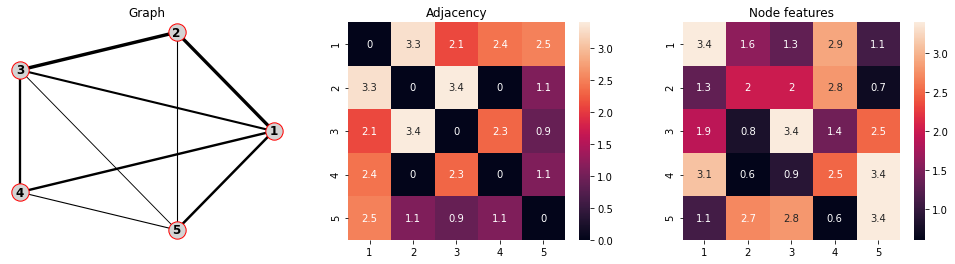

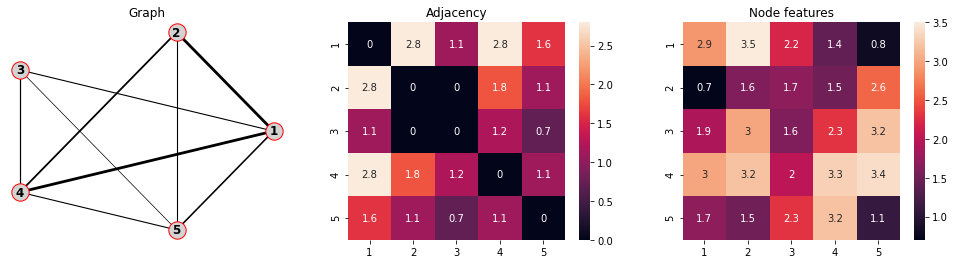

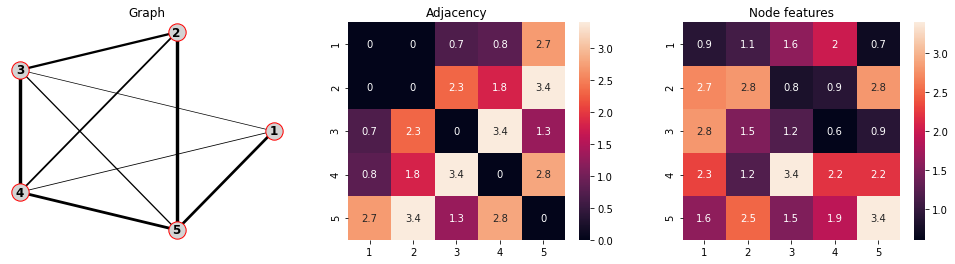

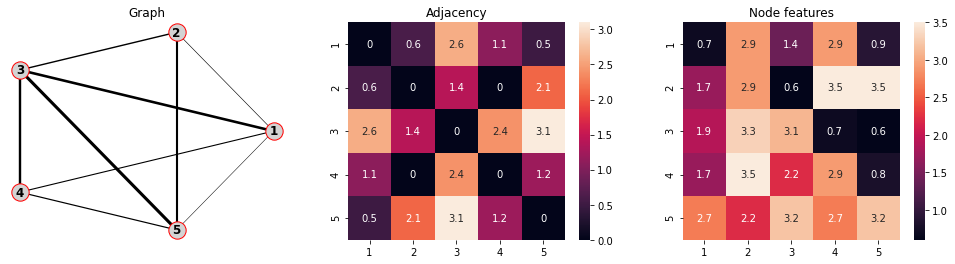

In [6]:
for i in range(m):
    plot_graph(graphs[i])
    # fix indexes

The left and right heatmaps are the <b>adjacency</b> and <b>node features'</b> matrices, respectively.<br>
We can also notice the variation of the edge <i>thickness</i> in the graph depending on the edge <i>weight</i>.

# 2. GCN training 

In this section, we will train a <b>GCN model</b> with the generated dataset of graphs. <br>
In the following cell, we will format the dataset to adapt it to the <b>Pytorch</b> framework.

In [7]:
class GraphSampler(torch.utils.data.Dataset):
    
    def __init__(self, G_list):
        self.adj_all = []
        self.label_all = []
        self.id_all = []
        self.feat_all = []
        
        for i in range(len(G_list)):
            self.adj_all.append(G_list[i]['adj'])
            self.feat_all.append(G_list[i]['feat'])
            self.label_all.append(G_list[i]['label'])
            self.id_all.append(G_list[i]['id'])

    def __len__(self):
        return len(self.adj_all)

    def __getitem__(self, idx):
        return {'adj':self.adj_all[idx],
                'feat':self.feat_all[idx],
                'label':self.label_all[idx],
                'id':self.id_all[idx]}

In the following cell, we define an elementary <i>GCN layer</i>. <br>
This implementation is similar to https://arxiv.org/abs/1609.02907

In [8]:
class GraphConvolution(Module):
    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

In this cell, we define the whole <i>GCN model</i>.

In [9]:
class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GCN, self).__init__()
        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, nclass)
        self.dropout = dropout
        self.LinearLayer = nn.Linear(nfeat,1)
        self.is_trained = False

    def forward(self, x, adj):
        x_1 = F.relu(self.gc1(x, adj))
        x_2 = F.dropout(x_1, self.dropout, training=self.training)
        x_3 = self.gc2(x_2, adj)
        x_4 = F.log_softmax(x_3, dim=1)
        x_5 = self.LinearLayer(torch.transpose(x_4,0,1))
        x_6 = torch.transpose(x_5,0,1)
        return x_6, [x_1,x_2,x_3,x_4,x_5]
    
    def loss(self, pred, label, type='softmax'):
        # softmax + CE
        
        return F.cross_entropy(pred, label, reduction='mean')

Here, we initialize the dataloader.

In [10]:
dataset_sampler = GraphSampler(graphs_list)
train_dataset_loader = torch.utils.data.DataLoader(dataset_sampler, batch_size = 1, shuffle = False)  

In the following cell, we instanciate the GCN model, the parameters and the optimizer. <br>
The parameters are <b>all the learnable weights</b> contained in the GCN model.

In [11]:
# dimension of the hidden layer
h = 20
model_GCN = GCN(nfeat = n,
                nhid = h,
                nclass = c,
                dropout = 0.0)
params = list(model_GCN.parameters()) 
optimizer = torch.optim.Adam(params, lr=0.001)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In the following cell, we train the GCN model with our generated dataset. 

In [12]:
num_epochs = 100
train_loss=[]
for epoch in range(num_epochs):
    print("Epoch ",epoch)
    model_GCN.train()
    total_time = 0
    sum_loss = 0.0
    preds = []
    labels = []
    for batch_idx, data in enumerate(train_dataset_loader):
        begin_time = time.time()
            
        adj = Variable(data['adj'].float(), requires_grad=False).to(device)
        feat = Variable(data['feat'].float(), requires_grad=False).to(device)
        label = Variable(data['label'].long()).to(device)
        adj_id = Variable(data['id'].int()).to(device)
        adj = torch.squeeze(adj)
        feat = torch.squeeze(feat)
        ypred , _ = model_GCN(feat, adj)    
        _, indices = torch.max(ypred, 1)
        preds.append(indices.cpu().data.numpy())
        labels.append(data['label'].long().numpy())
        loss = model_GCN.loss(ypred, label)
        model_GCN.zero_grad()
        # calculate the derivatives
        loss.backward()
        # update the weights
        optimizer.step()
            
        sum_loss += loss
        elapsed = time.time() - begin_time
        total_time += elapsed
        
    preds = np.hstack(preds)
    labels = np.hstack(labels)
    print("Train accuracy : ", np.mean( preds == labels ))
    print('Loss: ', sum_loss, '; epoch time: ', total_time)
    train_loss.append(sum_loss.item())

Epoch  0
Train accuracy :  0.5
Loss:  tensor(12.4250, grad_fn=<AddBackward0>) ; epoch time:  0.005987405776977539
Epoch  1
Train accuracy :  0.25
Loss:  tensor(8.5282, grad_fn=<AddBackward0>) ; epoch time:  0.004988193511962891
Epoch  2
Train accuracy :  0.25
Loss:  tensor(6.8387, grad_fn=<AddBackward0>) ; epoch time:  0.004984855651855469
Epoch  3
Train accuracy :  0.5
Loss:  tensor(6.0483, grad_fn=<AddBackward0>) ; epoch time:  0.00498509407043457
Epoch  4
Train accuracy :  0.5
Loss:  tensor(5.2443, grad_fn=<AddBackward0>) ; epoch time:  0.0019943714141845703
Epoch  5
Train accuracy :  0.25
Loss:  tensor(4.5605, grad_fn=<AddBackward0>) ; epoch time:  0.003994941711425781
Epoch  6
Train accuracy :  0.25
Loss:  tensor(4.1924, grad_fn=<AddBackward0>) ; epoch time:  0.003991127014160156
Epoch  7
Train accuracy :  0.25
Loss:  tensor(4.1325, grad_fn=<AddBackward0>) ; epoch time:  0.003989696502685547
Epoch  8
Train accuracy :  0.25
Loss:  tensor(4.1265, grad_fn=<AddBackward0>) ; epoch time

Loss:  tensor(0.5509, grad_fn=<AddBackward0>) ; epoch time:  0.003988742828369141
Epoch  98
Train accuracy :  1.0
Loss:  tensor(0.5397, grad_fn=<AddBackward0>) ; epoch time:  0.003988981246948242
Epoch  99
Train accuracy :  1.0
Loss:  tensor(0.5276, grad_fn=<AddBackward0>) ; epoch time:  0.0049893856048583984


In this cell, we will plot the training loss of our model.

<AxesSubplot:xlabel='epoch', ylabel='loss'>

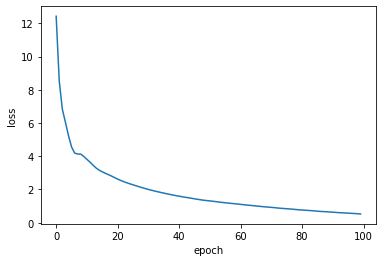

In [13]:
#print(train_loss)
epochs = [i for i in range(len(train_loss))]
df = pd.DataFrame(list(zip(epochs, train_loss)),
               columns =['epoch', 'loss'])

sns.lineplot(data=df, x="epoch", y="loss")

# 3. Step by step visualization of a single GC layer

In the following cells, we will focus on how <b>one single example</b> from the dataset goes through the different layers of the GCN model.

In [14]:
# pick a graph from the dataset
graph_idx = 2

adj = Variable(torch.from_numpy(graphs_list[graph_idx]['adj']).float(), requires_grad=False).to(device)
feat = Variable(torch.from_numpy(graphs_list[graph_idx]['feat']).float(), requires_grad=False).to(device)

adj = torch.squeeze(adj)
feat = torch.squeeze(feat)
ypred , intermediate_steps = model_GCN(feat, adj)

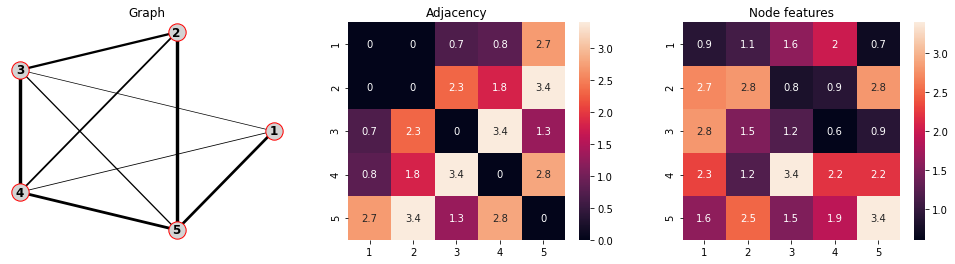

In [15]:
plot_graph(graphs[graph_idx])
#add captions for sub images

The following cell displays the architecture of the GCN model.

In [16]:
model_GCN

GCN(
  (gc1): GraphConvolution (5 -> 20)
  (gc2): GraphConvolution (20 -> 2)
  (LinearLayer): Linear(in_features=5, out_features=1, bias=True)
)

Now, we visualize the weights of the <b>1st GC layer</b>.

<AxesSubplot:>

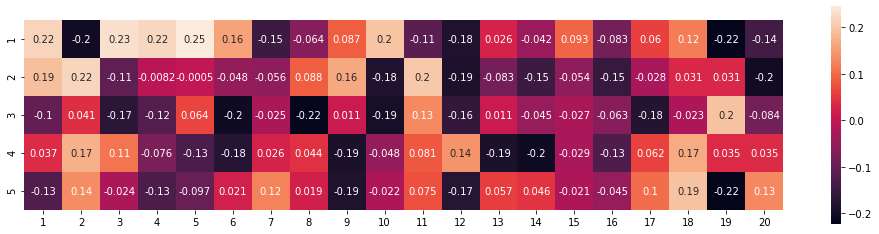

In [17]:
plt.figure(figsize=(17,4))
sns.heatmap(model_GCN.gc1.weight.cpu().detach().numpy(), annot=True, square=True, xticklabels=[i+1 for i in range(h)], yticklabels=[i+1 for i in range(n)])

Here, we display the output of the 1st GC layer. <br>
$ X_1 = ReLU(A \times (X_0 \times W_1) + b_1)$ <br>
with: <br>
$X_1 \in \mathbb{R}^{n \times h}$: the node features matrix at the $1^{st}$ layer. <br>
$A \in \mathbb{R}^{n \times n}$: the adjacency matrix. <br>
$W_1 \in \mathbb{R}^{n \times h}$: the weights matrix of the $1^{st}$ layer. <br>
$b_1$: the bias vector of the $1^{st}$ layer. <br>
$h$: the dimension of the hidden layer.

<AxesSubplot:>

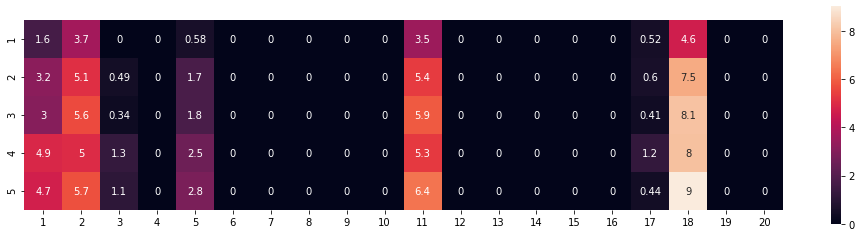

In [18]:
plt.figure(figsize=(17,4))
sns.heatmap(intermediate_steps[0].cpu().detach().numpy(), annot=True, square=True, xticklabels=[i+1 for i in range(h)], yticklabels=[i+1 for i in range(n)])

Here, we  manually make the intermediate calcualtions of the 1st GC layer.

<AxesSubplot:>

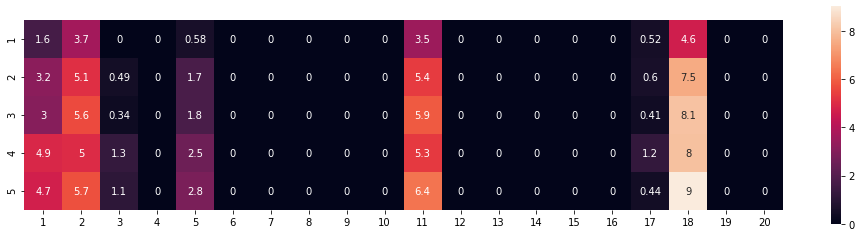

In [19]:
plt.figure(figsize=(17,4))
test = F.relu(torch.mm(adj, torch.mm(feat, model_GCN.gc1.weight))+model_GCN.gc1.bias)
sns.heatmap(test.cpu().detach().numpy(), annot=True, square=True, xticklabels=[i+1 for i in range(h)], yticklabels=[i+1 for i in range(n)])

Now, we visualize the weights of the <b>2nd GC layer</b>. <br>
$ X_2 = A \times (X_1 \times W_2) + b_2$ <br>
with: <br>
$X_2 \in \mathbb{R}^{n \times c}$: the node features matrix at the $2^{nd}$ layer. <br>
$A \in \mathbb{R}^{n \times n}$: the adjacency matrix. <br>
$W_2 \in \mathbb{R}^{h \times c}$: the weights matrix of the $2^{nd}$ layer. <br>
$b_2 \in \mathbb{R}^{c}$: the bias vector of the $2^{nd}$ layer. <br>
$h$: dimension of the hidden layer. <br>
$c$: number of classes.

<AxesSubplot:>

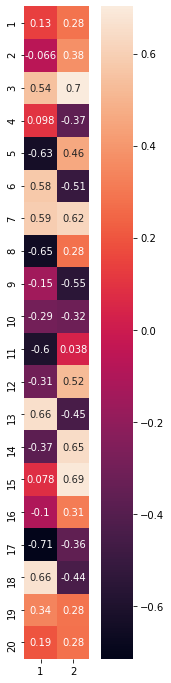

In [20]:
plt.figure(figsize=(4,12))
sns.heatmap(model_GCN.gc2.weight.cpu().detach().numpy(), annot=True, square=True, xticklabels=[i+1 for i in range(c)], yticklabels=[i+1 for i in range(h)])

In the following cell, we display the output of the <b> 2nd GC layer</b>.

<AxesSubplot:>

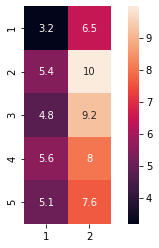

In [21]:
sns.heatmap(intermediate_steps[2].cpu().detach().numpy(), annot=True, square=True, xticklabels=[i+1 for i in range(c)], yticklabels=[i+1 for i in range(n)])

Here, we  manually make the intermediate calcualtions of the 2nd GC layer.

<AxesSubplot:>

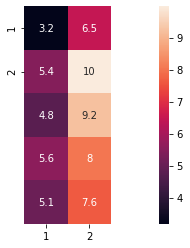

In [22]:
plt.figure(figsize=(17,4))
test = torch.mm(adj, torch.mm(intermediate_steps[1], model_GCN.gc2.weight))+model_GCN.gc2.bias
sns.heatmap(test.cpu().detach().numpy(), annot=True, square=True, xticklabels=[i+1 for i in range(c)], yticklabels=[i+1 for i in range(c)])

The following cell displays the resulting output after applying the <b> softmax</b>.

<AxesSubplot:>

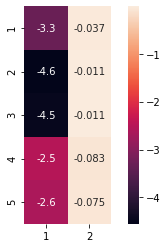

In [23]:
sns.heatmap(intermediate_steps[3].cpu().detach().numpy(), annot=True, square=True, xticklabels=[i+1 for i in range(c)], yticklabels=[i+1 for i in range(n)])

If we apply the the regular softmax, the output would be the following.

<AxesSubplot:>

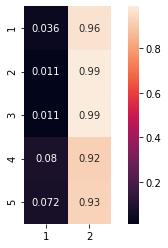

In [24]:
regular_softmax = nn.Softmax(dim=1)
regular_softmax_output = regular_softmax(intermediate_steps[2])
sns.heatmap(regular_softmax_output.cpu().detach().numpy(), annot=True, square=True, xticklabels=[i+1 for i in range(c)], yticklabels=[i+1 for i in range(n)])

Now, we visualize the weights of the <b>linear layer</b>.

<AxesSubplot:>

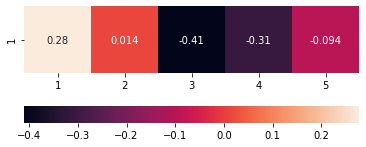

In [25]:
sns.heatmap(model_GCN.LinearLayer.weight.cpu().detach().numpy(), annot=True, square=True, xticklabels=[i+1 for i in range(n)], yticklabels=[1], cbar_kws={"orientation": "horizontal"})

The following cell displays the resulting output after applying the <b>linear layer</b>.

<AxesSubplot:>

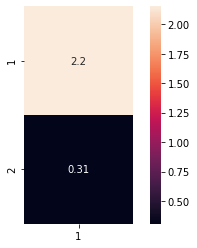

In [26]:
sns.heatmap(intermediate_steps[4].cpu().detach().numpy(), annot=True, square=True, xticklabels=[1], yticklabels=[i+1 for i in range(c)])

In the following cell, we display the prediction of the <i>GCN model</i> for the <b>selected training sample</b>.

In [27]:
print("The ground-truth label is: ",labels[graph_idx])
print("The predicted label is: ",torch.max(intermediate_steps[4], 0)[1].item())

The ground-truth label is:  0
The predicted label is:  0


Thank you!